In [2]:
# Step quartiles, best so far
import pandas as pd
import numpy as np
import tqdm

# Load the decile assignment result to get the Ticker-PERMNO mapping
decile_assignment_result_file = '/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/try_decile_assignment_general.csv'
decile_assignment_df = pd.read_csv(decile_assignment_result_file)

# Create a mapping from TICKER to PERMNO
ticker_to_permno = decile_assignment_df[['TICKER', 'permno']].drop_duplicates().set_index('TICKER')['permno'].to_dict()

# Load the monthly return data file once
monthly_return_data_file = '/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/MonthlyReturnData.csv'
monthly_return_df = pd.read_csv(monthly_return_data_file)
monthly_return_df['date'] = pd.to_datetime(monthly_return_df['date'])
monthly_return_df['RET'] = pd.to_numeric(monthly_return_df['RET'], errors='coerce')
monthly_return_df.set_index('date', inplace=True)

def fetch_monthly_returns(ticker):
    # Get the PERMNO for the ticker
    permno = ticker_to_permno.get(ticker)
    if not permno:
        return pd.DataFrame()  # No PERMNO found for the ticker

    # Filter the monthly return data for the specified PERMNO
    stock_data = monthly_return_df[monthly_return_df['PERMNO'] == permno][['RET']].copy()
    stock_data.dropna(subset=['RET'], inplace=True)
    stock_data['TICKER'] = ticker
    return stock_data

def calculate_monthly_returns_for_quartiles(adjusted_returns, quartile_series, variable):
    aggregated_monthly_returns = pd.DataFrame(index=adjusted_returns.index.unique())
    for quartile_label in range(5):  # Quartiles 0 to 4
        quartile_data = adjusted_returns[quartile_series == quartile_label]
        monthly_avg_returns = quartile_data.groupby(quartile_data.index)['RET'].mean()
        aggregated_monthly_returns[f'{variable}_quartile_{quartile_label}'] = monthly_avg_returns
    return aggregated_monthly_returns

def calculate_quartile_boundaries(df, variable):
    non_zero_data = df[df[variable] != 0][variable].dropna()
    if non_zero_data.empty:
        print(f"No non-zero data found for variable {variable}")
        return [None] * 5  # Return empty boundaries if no data
    
    # Calculate the boundaries
    quartiles = [0] + list(np.percentile(non_zero_data, [25, 50, 75])) + [non_zero_data.max()]
    
    return quartiles

def assign_quartiles(df, variable, boundaries):
    # Create quartile column initialized to NaN
    df[f'{variable}_quartile'] = np.nan
    
    # Assign 0s to quartile 0
    df.loc[df[variable] == 0, f'{variable}_quartile'] = 0

    # Assign values based on the boundaries
    for quartile in range(1, 5):
        min_val = boundaries[quartile - 1]
        max_val = boundaries[quartile]
        df.loc[(df[variable] > min_val) & (df[variable] <= max_val), f'{variable}_quartile'] = quartile
    
    return df[f'{variable}_quartile']

def process_data(ratios_df, columns_to_process=None):
    ratios_df['Date'] = pd.to_datetime(ratios_df['Date'], errors='coerce').dt.to_period('M')
    all_aggregated_results = pd.DataFrame()
    ticker_data_dict = {}
    quartile_ranges_dict = {}

    # Fetch data for each ticker
    for ticker in tqdm.tqdm(ratios_df['TICKER'].dropna().unique(), desc="Fetching ticker data"):
        ticker_data = fetch_monthly_returns(ticker)
        if not ticker_data.empty:
            ticker_data.index = ticker_data.index.to_period('M')
            ticker_data_dict[ticker] = ticker_data

    if columns_to_process is None:
        columns_to_process = ratios_df.columns[5:]

    print("Available columns to process:", columns_to_process)

    for variable in tqdm.tqdm(columns_to_process, desc="Calculating and Assigning Quartiles"):
        boundaries = calculate_quartile_boundaries(ratios_df, variable)
        quartile_ranges_dict[variable] = boundaries  # Store boundaries for output
        
        ratios_df[f'{variable}_quartile'] = assign_quartiles(ratios_df, variable, boundaries)

        # Calculate monthly averages by quartile for each ticker
        monthly_data_list = []
        for ticker, ticker_data in ticker_data_dict.items():
            ticker_quartiles = ratios_df[ratios_df['TICKER'] == ticker][['Date', f'{variable}_quartile']]
            for _, row in ticker_quartiles.iterrows():
                date_filter = ticker_data.index >= row['Date']
                ticker_data.loc[date_filter, f'{variable}_quartile'] = row[f'{variable}_quartile']
            monthly_data_list.append(ticker_data)

        if not monthly_data_list:
            continue

        ticker_data_combined = pd.concat(monthly_data_list)
        monthly_returns_for_quartiles = calculate_monthly_returns_for_quartiles(
            ticker_data_combined, ticker_data_combined[f'{variable}_quartile'], variable
        )
        
        if all_aggregated_results.empty:
            all_aggregated_results = monthly_returns_for_quartiles
        else:
            all_aggregated_results = all_aggregated_results.join(monthly_returns_for_quartiles, how='outer', rsuffix=f'_{variable}')

    all_aggregated_results.sort_index(inplace=True)
    output_file_path = 'words_quartiles_general_big_dataset_quartiles_analyst.csv'
    all_aggregated_results.to_csv(output_file_path)
    print(f"Quartile monthly averages saved to {output_file_path}.")

    # Output the quartile ranges
    quartile_ranges_df = pd.DataFrame(quartile_ranges_dict, index=['Q0_min', 'Q1_min', 'Q2_min', 'Q3_min', 'Q4_max'])
    quartile_ranges_output_path = 'quartile_ranges_output_analyst.csv'
    quartile_ranges_df.to_csv(quartile_ranges_output_path)
    print(f"Quartile ranges saved to {quartile_ranges_output_path}")

# Example usage:
ratios_df = pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/Analyst/def_and_def_final/tech_sentiment_analysis_analyst_words_def_and_def_final.csv')
columns_to_process = [
    "bryan Total Count", "bryan Positive Count", "bryan Negative Count",
    "anthony Total Count", "anthony Positive Count", "anthony Negative Count",
    "lee Total Count", "lee Positive Count", "lee Negative Count",
    "jeffrey Total Count", "jeffrey Positive Count", "jeffrey Negative Count",
    "jeff Total Count", "jeff Positive Count", "jeff Negative Count",
    "doug Total Count", "doug Positive Count", "doug Negative Count",
    "terry Total Count", "terry Positive Count", "terry Negative Count",
    "tom Total Count", "tom Positive Count", "tom Negative Count",
    "craig Total Count", "craig Positive Count", "craig Negative Count",
    "josh Total Count", "josh Positive Count", "josh Negative Count",
    "gary Total Count", "gary Positive Count", "gary Negative Count",
    "ryan Total Count", "ryan Positive Count", "ryan Negative Count",
    "daniel Total Count", "daniel Positive Count", "daniel Negative Count",
    "dan Total Count", "dan Positive Count", "dan Negative Count",
    "stephen Total Count", "stephen Positive Count", "stephen Negative Count",
    "davis Total Count", "davis Positive Count", "davis Negative Count",
    "bob Total Count", "bob Positive Count", "bob Negative Count",
    "thomas Total Count", "thomas Positive Count", "thomas Negative Count",
    "ed Total Count", "ed Positive Count", "ed Negative Count",
    "scott Total Count", "scott Positive Count", "scott Negative Count",
    "adam Total Count", "adam Positive Count", "adam Negative Count",
    "brent Total Count", "brent Positive Count", "brent Negative Count",
    "jim Total Count", "jim Positive Count", "jim Negative Count"
]

process_data(ratios_df, columns_to_process)


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_4635/3657092850.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  monthly_return_df = pd.read_csv(monthly_return_data_file)
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_4635/3657092850.py:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  monthly_return_df['date'] = pd.to_datetime(monthly_return_df['date'])
Fetching ticker data: 100%|██████████| 520/520 [00:01<00:00, 263.80it/s]


Available columns to process: ['bryan Total Count', 'bryan Positive Count', 'bryan Negative Count', 'anthony Total Count', 'anthony Positive Count', 'anthony Negative Count', 'lee Total Count', 'lee Positive Count', 'lee Negative Count', 'jeffrey Total Count', 'jeffrey Positive Count', 'jeffrey Negative Count', 'jeff Total Count', 'jeff Positive Count', 'jeff Negative Count', 'doug Total Count', 'doug Positive Count', 'doug Negative Count', 'terry Total Count', 'terry Positive Count', 'terry Negative Count', 'tom Total Count', 'tom Positive Count', 'tom Negative Count', 'craig Total Count', 'craig Positive Count', 'craig Negative Count', 'josh Total Count', 'josh Positive Count', 'josh Negative Count', 'gary Total Count', 'gary Positive Count', 'gary Negative Count', 'ryan Total Count', 'ryan Positive Count', 'ryan Negative Count', 'daniel Total Count', 'daniel Positive Count', 'daniel Negative Count', 'dan Total Count', 'dan Positive Count', 'dan Negative Count', 'stephen Total Count'

Calculating and Assigning Quartiles: 100%|██████████| 69/69 [07:01<00:00,  6.11s/it]


Quartile monthly averages saved to words_quartiles_general_big_dataset_quartiles_analyst.csv.
Quartile ranges saved to quartile_ranges_output_analyst.csv


In [11]:
# Step 5 - Individual option GRS
from tqdm import tqdm
from scipy.stats import f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Define the cutoff years
cutoff_year = 2003
cutoff_max_year = 2019

# Function to preprocess dates, filter by cutoff years, and group by month
def preprocess_and_group_by_month(data, date_col, date_format=None):
    """Preprocess the dataset by converting the date column, filtering by year range, and aggregating by month."""
    if date_format:
        data['date'] = pd.to_datetime(data[date_col], format=date_format, errors='coerce')
    else:
        data['date'] = pd.to_datetime(data[date_col], errors='coerce')
    
    invalid_dates = data['date'].isna().sum()
    if invalid_dates > 0:
        print(f"Found {invalid_dates} invalid dates. Examples:")
        print(data[data['date'].isna()][date_col].head())
    
    # Filter by cutoff years
    data = data[(data['date'].dt.year >= cutoff_year) & (data['date'].dt.year < cutoff_max_year)]
    print(f"Data filtered to include only rows from {cutoff_year} to {cutoff_max_year - 1}. Remaining rows: {len(data)}")
    
    # Group by year and month to ensure one row per month
    data['year_month'] = data['date'].dt.to_period('M')
    data_grouped = data.groupby('year_month').mean(numeric_only=True).reset_index()
    data_grouped['date'] = data_grouped['year_month'].dt.to_timestamp()
    data_grouped.drop(columns=['year_month'], inplace=True)
    
    return data_grouped

# Preprocess datasets

# Varaince def words_quartiles_general_big_dataset_quartiles_variance_weighted_output_def_ulti_JoF_thr_CORRECT factor_analysis_results_variance_def USING weighted_output_def_ulti_JoF_thr
# idf original words_quartiles_general_big_dataset_quartiles_JoF_relative_count_tf_idf_mod factor_analysis_results_tf_idf_mod
# words_quartiles_general_big_dataset_quartiles_JoF_relative_count_tf_idf factor_analysis_results_tf_idf
# 'Weighted_Total_quartile_1', 'Weighted_Total_quartile_2', 'Weighted_Total_quartile_3', 'Weighted_Total_quartile_4','Weighted_Positive_quartile_1', 'Weighted_Positive_quartile_2', 'Weighted_Positive_quartile_3', 'Weighted_Positive_quartile_4','Weighted_Negative_quartile_1', 'Weighted_Negative_quartile_2', 'Weighted_Negative_quartile_3', 'Weighted_Negative_quartile_4'

# words_quartiles_general_big_dataset_quartiles_JoF_pos_neg_bis factor_analysis_results_variance_pos_neg
# 'Weighted_Pos_Neg_quartile_2','Weighted_Pos_Neg_quartile_3','Weighted_Pos_Neg_quartile_4'

decile_returns = preprocess_and_group_by_month(
    pd.read_csv('words_quartiles_general_big_dataset_quartiles_weighted_def_and_def_final_analyst_2.csv'),
    'Date',
    date_format='%d/%m/%Y'
)

fama_french = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/Market_monthly_ff.csv'),
    'dateff'
)

portfolio_returns = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/grouped_average_returns_big_dataset_II.csv'),
    'Date'
)
original_factors = ['mktrf', 'smb', 'hml', 'rmw', 'cma']
# Merge datasets on the aggregated monthly date
combined_data = pd.merge(fama_french, decile_returns, on='date', how='outer', indicator='merge_status_ff')
print(f"\nFirst merge completed. Rows: {len(combined_data)}")

combined_data = pd.merge(combined_data, portfolio_returns, on='date', how='outer', indicator='merge_status_pr')
print(f"\nSecond merge completed. Rows: {len(combined_data)}")

# Print debugging information for missing dates
print("Dates missing in one dataset during merges:")
print(combined_data[(combined_data['merge_status_ff'] != 'both') | (combined_data['merge_status_pr'] != 'both')]['date'])

# Save the merged data for inspection
combined_data.to_csv('test_why_aggregated_monthly_cutoffs.csv', index=False)
print(f"Merged data saved to test_why_aggregated_monthly_cutoffs.csv")

decile_columns = ['Weighted_Total_quartile_1', 'Weighted_Total_quartile_2', 'Weighted_Total_quartile_3', 'Weighted_Total_quartile_4','Weighted_Positive_quartile_1', 'Weighted_Positive_quartile_2', 'Weighted_Positive_quartile_3', 'Weighted_Positive_quartile_4','Weighted_Negative_quartile_1', 'Weighted_Negative_quartile_2', 'Weighted_Negative_quartile_3', 'Weighted_Negative_quartile_4','Weighted_Pos_Neg_quartile_2','Weighted_Pos_Neg_quartile_3','Weighted_Pos_Neg_quartile_4']
# Make a copy of the combined data for processing
adjusted_combined_data = combined_data.copy()

# Clean the data
adjusted_combined_data = adjusted_combined_data.replace([np.inf, -np.inf], np.nan)
adjusted_combined_data.dropna(subset=decile_columns + ['mktrf'] + original_factors, inplace=True)
print(f"Data cleaned. Remaining rows: {len(adjusted_combined_data)}")

# Delete the first row from adjusted_combined_data
adjusted_combined_data = adjusted_combined_data.iloc[1:].reset_index(drop=True)

adjusted_combined_data.to_csv('cleaned_combined_data.csv', index=False)


for col in decile_columns:
    adjusted_combined_data[col] = adjusted_combined_data[col] - adjusted_combined_data['mktrf']


# Function to calculate VIF for given factors
def calculate_vif(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)  # Add intercept term

    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Function to calculate heteroscedasticity (Breusch-Pagan test)
def calculate_heteroscedasticity(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)
    y = adjusted_combined_data[portfolio_columns].mean(axis=1)  # Portfolio average as the dependent variable
    model = OLS(y, X).fit()
    _, pval, _, _ = het_breuschpagan(model.resid, X)
    return pval

# Function to calculate adjusted R^2
def calculate_adjusted_r2(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)
    y = adjusted_combined_data[portfolio_columns].mean(axis=1)  # Portfolio average as the dependent variable
    model = OLS(y, X).fit()
    return model.rsquared_adj

# Function to calculate average return, intercept, and standard deviation for each factor
def calculate_factor_statistics(factor):
    returns = adjusted_combined_data[factor]
    avg_return = returns.mean()
    intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
    std_dev = returns.std()
    return avg_return, intercept, std_dev

# Function to perform the GRS test
def calculate_grs(factor_columns, portfolio_columns):
    factors = adjusted_combined_data[factor_columns].values
    portfolios = adjusted_combined_data[portfolio_columns].values

    if portfolios.ndim == 1:
        portfolios = portfolios.reshape(-1, 1)

    # Add intercept
    factors = sm.add_constant(factors)

    # Estimate alpha and residuals
    betas = np.linalg.inv(factors.T @ factors) @ (factors.T @ portfolios)
    residuals = portfolios - (factors @ betas)
    alphas = betas[0, :].reshape(-1, 1)

    # GRS test calculation
    iT, iK = residuals.shape
    iJ = factors.shape[1] - 1  # Exclude intercept
    mCov = np.cov(residuals, rowvar=False)
    vMuRF = np.mean(factors[:, 1:], axis=0).reshape(1, iJ)
    mCovRF = np.cov(factors[:, 1:], rowvar=False)
    dTestStat = (iT / iK) * ((iT - iK - iJ) / (iT - iJ - 1)) * \
                (alphas.T @ np.linalg.inv(mCov) @ alphas) / \
                (1 + vMuRF @ np.linalg.inv(mCovRF) @ vMuRF.T)
    pVal = 1 - f.cdf(dTestStat[0, 0], iK, iT - iK - 1)
    return dTestStat[0, 0], pVal

# Analyze the 5 original factors
original_factors = [ 'mktrf','smb', 'hml', 'rmw', 'cma']
portfolio_columns = [col for col in portfolio_returns.columns if col != 'date']

original_vif = calculate_vif(original_factors)
original_heteroscedasticity_pval = calculate_heteroscedasticity(original_factors)
original_adjusted_r2 = calculate_adjusted_r2(original_factors)
original_grs_stat, original_grs_pval = calculate_grs(original_factors, portfolio_columns)

# Calculate statistics for original factors
original_factor_stats = {
    factor: calculate_factor_statistics(factor) for factor in original_factors
}

# Store results for original 5 factors
original_results = {
    'Factor': 'Original 5 Factors',
    'VIF': original_vif['VIF'].max() if original_vif is not None else None,
    'Heteroscedasticity_Pval': original_heteroscedasticity_pval,
    'Adjusted_R2': original_adjusted_r2,
    'GRS_Statistic': original_grs_stat,
    'GRS_Pval': original_grs_pval,
    'Avg_Return': np.mean([stat[0] for stat in original_factor_stats.values()]),
    'Intercept': np.mean([stat[1] for stat in original_factor_stats.values()]),
    'Std_Dev': np.mean([stat[2] for stat in original_factor_stats.values()])
}

# Run tests for all additional factors
all_results = [original_results]

for factor in decile_columns:
    if factor not in adjusted_combined_data.columns:
        print(f"Skipping factor '{factor}' as it is not in the DataFrame columns.")
        continue  # Skip to the next factor if not present in the DataFrame

    if factor not in original_factors:  # Exclude already included factors
        factor_columns = original_factors + [factor]

        vif_results = calculate_vif(factor_columns)
        heteroscedasticity_pval = calculate_heteroscedasticity(factor_columns)
        adjusted_r2 = calculate_adjusted_r2(factor_columns)
        grs_stat, grs_pval = calculate_grs(factor_columns, portfolio_columns)

        avg_return, intercept, std_dev = calculate_factor_statistics(factor)

        all_results.append({
            'Factor': factor,
            'VIF': vif_results['VIF'].max() if vif_results is not None else None,
            'Heteroscedasticity_Pval': heteroscedasticity_pval,
            'Adjusted_R2': adjusted_r2,
            'GRS_Statistic': grs_stat,
            'GRS_Pval': grs_pval,
            'Avg_Return': avg_return,
            'Intercept': intercept,
            'Std_Dev': std_dev
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(all_results)

# Save Results
results_df.to_csv('factor_analysis_results_variance_def_2.csv', index=False)

# Output Results
print("\nFactor Analysis Results:")
print(results_df)


Data filtered to include only rows from 2003 to 2018. Remaining rows: 192
Data filtered to include only rows from 2003 to 2018. Remaining rows: 192
Data filtered to include only rows from 2003 to 2018. Remaining rows: 191

First merge completed. Rows: 192

Second merge completed. Rows: 192
Dates missing in one dataset during merges:
0   2003-01-01
Name: date, dtype: datetime64[ns]
Merged data saved to test_why_aggregated_monthly_cutoffs.csv
Data cleaned. Remaining rows: 192


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns)))


Factor Analysis Results:
                          Factor       VIF  Heteroscedasticity_Pval  \
0             Original 5 Factors  1.453594                 0.085382   
1      Weighted_Total_quartile_1  2.234256                 0.031372   
2      Weighted_Total_quartile_2  1.841680                 0.062113   
3      Weighted_Total_quartile_3  1.935015                 0.091623   
4      Weighted_Total_quartile_4  1.710895                 0.071596   
5   Weighted_Positive_quartile_1  1.924461                 0.003513   
6   Weighted_Positive_quartile_2  1.909641                 0.071514   
7   Weighted_Positive_quartile_3  1.981844                 0.068282   
8   Weighted_Positive_quartile_4  1.613203                 0.297805   
9   Weighted_Negative_quartile_1  2.403777                 0.093177   
10  Weighted_Negative_quartile_2  1.835079                 0.160323   
11  Weighted_Negative_quartile_3  1.802269                 0.014983   
12  Weighted_Negative_quartile_4  1.645601         

/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/2039088305.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will 

In [24]:
# Step 5 - Individual option GRS
from tqdm import tqdm
from scipy.stats import f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Define the cutoff years
cutoff_year = 2003
cutoff_max_year = 2019

# Function to preprocess dates, filter by cutoff years, and group by month
def preprocess_and_group_by_month(data, date_col, date_format=None):
    """Preprocess the dataset by converting the date column, filtering by year range, and aggregating by month."""
    if date_format:
        data['date'] = pd.to_datetime(data[date_col], format=date_format, errors='coerce')
    else:
        data['date'] = pd.to_datetime(data[date_col], errors='coerce')
    
    invalid_dates = data['date'].isna().sum()
    if invalid_dates > 0:
        print(f"Found {invalid_dates} invalid dates. Examples:")
        print(data[data['date'].isna()][date_col].head())
    
    # Filter by cutoff years
    data = data[(data['date'].dt.year >= cutoff_year) & (data['date'].dt.year < cutoff_max_year)]
    print(f"Data filtered to include only rows from {cutoff_year} to {cutoff_max_year - 1}. Remaining rows: {len(data)}")
    
    # Group by year and month to ensure one row per month
    data['year_month'] = data['date'].dt.to_period('M')
    data_grouped = data.groupby('year_month').mean(numeric_only=True).reset_index()
    data_grouped['date'] = data_grouped['year_month'].dt.to_timestamp()
    data_grouped.drop(columns=['year_month'], inplace=True)
    
    return data_grouped

# Preprocess datasets

# Varaince def words_quartiles_general_big_dataset_quartiles_variance_weighted_output_def_ulti_JoF_thr_CORRECT factor_analysis_results_variance_def USING weighted_output_def_ulti_JoF_thr
# idf original words_quartiles_general_big_dataset_quartiles_JoF_relative_count_tf_idf_mod factor_analysis_results_tf_idf_mod
# words_quartiles_general_big_dataset_quartiles_JoF_relative_count_tf_idf factor_analysis_results_tf_idf
# 'Weighted_Total_quartile_1', 'Weighted_Total_quartile_2', 'Weighted_Total_quartile_3', 'Weighted_Total_quartile_4','Weighted_Positive_quartile_1', 'Weighted_Positive_quartile_2', 'Weighted_Positive_quartile_3', 'Weighted_Positive_quartile_4','Weighted_Negative_quartile_1', 'Weighted_Negative_quartile_2', 'Weighted_Negative_quartile_3', 'Weighted_Negative_quartile_4'

# words_quartiles_general_big_dataset_quartiles_JoF_pos_neg_bis factor_analysis_results_variance_pos_neg
# 'Weighted_Pos_Neg_quartile_2','Weighted_Pos_Neg_quartile_3','Weighted_Pos_Neg_quartile_4'

decile_returns = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/Technichal/Technichal finito/words_quartiles_general_big_dataset_quartiles_weighted_def_and_def_final_technichal_2.csv'),
    'Date',
    date_format='%d/%m/%Y'
)

fama_french = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/Market_monthly_ff.csv'),
    'dateff'
)

portfolio_returns = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/grouped_average_returns_big_dataset_II.csv'),
    'Date'
)
original_factors = ['mktrf', 'smb', 'hml', 'rmw', 'cma']
# Merge datasets on the aggregated monthly date
combined_data = pd.merge(fama_french, decile_returns, on='date', how='outer', indicator='merge_status_ff')
print(f"\nFirst merge completed. Rows: {len(combined_data)}")

combined_data = pd.merge(combined_data, portfolio_returns, on='date', how='outer', indicator='merge_status_pr')
print(f"\nSecond merge completed. Rows: {len(combined_data)}")

# Print debugging information for missing dates
print("Dates missing in one dataset during merges:")
print(combined_data[(combined_data['merge_status_ff'] != 'both') | (combined_data['merge_status_pr'] != 'both')]['date'])

# Save the merged data for inspection
combined_data.to_csv('test_why_aggregated_monthly_cutoffs.csv', index=False)
print(f"Merged data saved to test_why_aggregated_monthly_cutoffs.csv")

decile_columns = ['Weighted_Total_quartile_1', 'Weighted_Total_quartile_2', 'Weighted_Total_quartile_3', 'Weighted_Total_quartile_4','Weighted_Positive_quartile_1', 'Weighted_Positive_quartile_2', 'Weighted_Positive_quartile_3', 'Weighted_Positive_quartile_4','Weighted_Negative_quartile_1', 'Weighted_Negative_quartile_2', 'Weighted_Negative_quartile_3', 'Weighted_Negative_quartile_4','Weighted_Pos_Neg_quartile_2','Weighted_Pos_Neg_quartile_3','Weighted_Pos_Neg_quartile_4']
# Make a copy of the combined data for processing
adjusted_combined_data = combined_data.copy()

# Clean the data
adjusted_combined_data = adjusted_combined_data.replace([np.inf, -np.inf], np.nan)
adjusted_combined_data.dropna(subset=decile_columns + ['mktrf'] + original_factors, inplace=True)
print(f"Data cleaned. Remaining rows: {len(adjusted_combined_data)}")

# Delete the first row from adjusted_combined_data
adjusted_combined_data = adjusted_combined_data.iloc[1:].reset_index(drop=True)

adjusted_combined_data.to_csv('cleaned_combined_data.csv', index=False)


for col in decile_columns:
    adjusted_combined_data[col] = adjusted_combined_data[col] - adjusted_combined_data['mktrf']


# Function to calculate VIF for given factors
def calculate_vif(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)  # Add intercept term

    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Function to calculate heteroscedasticity (Breusch-Pagan test)
def calculate_heteroscedasticity(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)
    y = adjusted_combined_data[portfolio_columns].mean(axis=1)  # Portfolio average as the dependent variable
    model = OLS(y, X).fit()
    _, pval, _, _ = het_breuschpagan(model.resid, X)
    return pval

# Function to calculate adjusted R^2
def calculate_adjusted_r2(factor_columns):
    X = adjusted_combined_data[factor_columns]
    X = sm.add_constant(X)
    y = adjusted_combined_data[portfolio_columns].mean(axis=1)  # Portfolio average as the dependent variable
    model = OLS(y, X).fit()
    return model.rsquared_adj

# Function to calculate average return, intercept, and standard deviation for each factor
def calculate_factor_statistics(factor):
    returns = adjusted_combined_data[factor]
    avg_return = returns.mean()
    intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
    std_dev = returns.std()
    return avg_return, intercept, std_dev

# Function to perform the GRS test
def calculate_grs(factor_columns, portfolio_columns):
    factors = adjusted_combined_data[factor_columns].values
    portfolios = adjusted_combined_data[portfolio_columns].values

    if portfolios.ndim == 1:
        portfolios = portfolios.reshape(-1, 1)

    # Add intercept
    factors = sm.add_constant(factors)

    # Estimate alpha and residuals
    betas = np.linalg.inv(factors.T @ factors) @ (factors.T @ portfolios)
    residuals = portfolios - (factors @ betas)
    alphas = betas[0, :].reshape(-1, 1)

    # GRS test calculation
    iT, iK = residuals.shape
    iJ = factors.shape[1] - 1  # Exclude intercept
    mCov = np.cov(residuals, rowvar=False)
    vMuRF = np.mean(factors[:, 1:], axis=0).reshape(1, iJ)
    mCovRF = np.cov(factors[:, 1:], rowvar=False)
    dTestStat = (iT / iK) * ((iT - iK - iJ) / (iT - iJ - 1)) * \
                (alphas.T @ np.linalg.inv(mCov) @ alphas) / \
                (1 + vMuRF @ np.linalg.inv(mCovRF) @ vMuRF.T)
    pVal = 1 - f.cdf(dTestStat[0, 0], iK, iT - iK - 1)
    return dTestStat[0, 0], pVal

# Analyze the 5 original factors
original_factors = [ 'mktrf','smb', 'hml', 'rmw', 'cma']
portfolio_columns = [col for col in portfolio_returns.columns if col != 'date']

original_vif = calculate_vif(original_factors)
original_heteroscedasticity_pval = calculate_heteroscedasticity(original_factors)
original_adjusted_r2 = calculate_adjusted_r2(original_factors)
original_grs_stat, original_grs_pval = calculate_grs(original_factors, portfolio_columns)

# Calculate statistics for original factors
original_factor_stats = {
    factor: calculate_factor_statistics(factor) for factor in original_factors
}

# Store results for original 5 factors
original_results = {
    'Factor': 'Original 5 Factors',
    'VIF': original_vif['VIF'].max() if original_vif is not None else None,
    'Heteroscedasticity_Pval': original_heteroscedasticity_pval,
    'Adjusted_R2': original_adjusted_r2,
    'GRS_Statistic': original_grs_stat,
    'GRS_Pval': original_grs_pval,
    'Avg_Return': np.mean([stat[0] for stat in original_factor_stats.values()]),
    'Intercept': np.mean([stat[1] for stat in original_factor_stats.values()]),
    'Std_Dev': np.mean([stat[2] for stat in original_factor_stats.values()])
}

# Run tests for all additional factors
all_results = [original_results]

for factor in decile_columns:
    if factor not in adjusted_combined_data.columns:
        print(f"Skipping factor '{factor}' as it is not in the DataFrame columns.")
        continue  # Skip to the next factor if not present in the DataFrame

    if factor not in original_factors:  # Exclude already included factors
        factor_columns = original_factors + [factor]

        vif_results = calculate_vif(factor_columns)
        heteroscedasticity_pval = calculate_heteroscedasticity(factor_columns)
        adjusted_r2 = calculate_adjusted_r2(factor_columns)
        grs_stat, grs_pval = calculate_grs(factor_columns, portfolio_columns)

        avg_return, intercept, std_dev = calculate_factor_statistics(factor)

        all_results.append({
            'Factor': factor,
            'VIF': vif_results['VIF'].max() if vif_results is not None else None,
            'Heteroscedasticity_Pval': heteroscedasticity_pval,
            'Adjusted_R2': adjusted_r2,
            'GRS_Statistic': grs_stat,
            'GRS_Pval': grs_pval,
            'Avg_Return': avg_return,
            'Intercept': intercept,
            'Std_Dev': std_dev
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(all_results)

# Save Results
results_df.to_csv('factor_analysis_results_variance_def_2_technichal.csv', index=False)

# Output Results
print("\nFactor Analysis Results:")
print(results_df)


Data filtered to include only rows from 2003 to 2018. Remaining rows: 192
Data filtered to include only rows from 2003 to 2018. Remaining rows: 192
Data filtered to include only rows from 2003 to 2018. Remaining rows: 191

First merge completed. Rows: 192

Second merge completed. Rows: 192
Dates missing in one dataset during merges:
0   2003-01-01
Name: date, dtype: datetime64[ns]
Merged data saved to test_why_aggregated_monthly_cutoffs.csv
Data cleaned. Remaining rows: 183


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fi


Factor Analysis Results:
                          Factor       VIF  Heteroscedasticity_Pval  \
0             Original 5 Factors  1.469421                 0.259802   
1      Weighted_Total_quartile_1  1.795054                 0.102125   
2      Weighted_Total_quartile_2  1.790868                 0.004228   
3      Weighted_Total_quartile_3  1.612172                 0.186475   
4      Weighted_Total_quartile_4  1.572438                 0.252581   
5   Weighted_Positive_quartile_1  1.856797                 0.028470   
6   Weighted_Positive_quartile_2  1.827461                 0.241874   
7   Weighted_Positive_quartile_3  1.544955                 0.499624   
8   Weighted_Positive_quartile_4  1.519702                 0.251441   
9   Weighted_Negative_quartile_1  1.752600                 0.130414   
10  Weighted_Negative_quartile_2  1.727515                 0.016555   
11  Weighted_Negative_quartile_3  1.625277                 0.366828   
12  Weighted_Negative_quartile_4  1.616842         

/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = sm.OLS(returns, sm.add_constant(np.ones_like(returns))).fit().params[0]
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/767111535.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import f

from tqdm import tqdm
from scipy.stats import f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Define the cutoff years
cutoff_year = 2003
cutoff_max_year = 2019

# Function to preprocess dates, filter by cutoff years, and group by month
def preprocess_and_group_by_month(data, date_col, date_format=None):
    """Preprocess the dataset by converting the date column, filtering by year range, and aggregating by month."""
    if date_format:
        data['date'] = pd.to_datetime(data[date_col], format=date_format, errors='coerce')
    else:
        data['date'] = pd.to_datetime(data[date_col], errors='coerce')
    
    invalid_dates = data['date'].isna().sum()
    if invalid_dates > 0:
        print(f"Found {invalid_dates} invalid dates. Examples:")
        print(data[data['date'].isna()][date_col].head())
    
    # Filter by cutoff years
    data = data[(data['date'].dt.year >= cutoff_year) & (data['date'].dt.year < cutoff_max_year)]
    print(f"Data filtered to include only rows from {cutoff_year} to {cutoff_max_year - 1}. Remaining rows: {len(data)}")
    
    # Group by year and month to ensure one row per month
    data['year_month'] = data['date'].dt.to_period('M')
    data_grouped = data.groupby('year_month').mean(numeric_only=True).reset_index()
    data_grouped['date'] = data_grouped['year_month'].dt.to_timestamp()
    data_grouped.drop(columns=['year_month'], inplace=True)
    
    return data_grouped

# Preprocess datasets
decile_returns = preprocess_and_group_by_month(
    pd.read_csv('words_quartiles_general_big_dataset_quartiles_analyst_partial.csv'),
    'Date',
    date_format='%d/%m/%Y'
)

fama_french = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/Market_monthly_ff.csv'),
    'dateff'
)

portfolio_returns = preprocess_and_group_by_month(
    pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/grouped_average_returns_big_dataset_II.csv'),
    'Date'
)
original_factors = ['mktrf', 'smb', 'hml', 'rmw', 'cma']
# Merge datasets on the aggregated monthly date
combined_data = pd.merge(fama_french, decile_returns, on='date', how='outer', indicator='merge_status_ff')
print(f"\nFirst merge completed. Rows: {len(combined_data)}")

combined_data = pd.merge(combined_data, portfolio_returns, on='date', how='outer', indicator='merge_status_pr')
print(f"\nSecond merge completed. Rows: {len(combined_data)}")

# Print debugging information for missing dates
print("Dates missing in one dataset during merges:")
print(combined_data[(combined_data['merge_status_ff'] != 'both') | (combined_data['merge_status_pr'] != 'both')]['date'])

# Save the merged data for inspection
combined_data.to_csv('test_why_aggregated_monthly_cutoffs.csv', index=False)
print(f"Merged data saved to test_why_aggregated_monthly_cutoffs.csv")

# Define Fama and French factor columns
ff_columns = ['mktrf', 'smb', 'hml', 'rmw', 'cma']

# Identify and filter out factors with less than 7 deciles
decile_columns = [col for col in decile_returns.columns if col != 'date']
factor_decile_counts = pd.Series([col.split('_quartile_')[0] for col in decile_columns]).value_counts()
valid_factors = factor_decile_counts[factor_decile_counts >= 2].index

# Filter decile_returns to include only valid factors
valid_decile_columns = [col for col in decile_columns if col.split('_quartile_')[0] in valid_factors]
decile_returns = decile_returns[['date'] + valid_decile_columns]
decile_returns = decile_returns[decile_returns['date'].dt.year >= cutoff_year]

# Update combined_data after filtering valid decile columns
combined_data = pd.merge(fama_french, decile_returns, on='date')
combined_data = pd.merge(combined_data, portfolio_returns, on='date')
combined_data = combined_data.drop(columns=['date']).dropna(axis=1)

# Function to perform the GRS test
def grs_test(resid: np.ndarray, alpha: np.ndarray, factors: np.ndarray) -> tuple:
    iT, iK = resid.shape
    iJ = factors.shape[1]
    assert alpha.shape == (iK, 1)
    assert factors.shape == (iT, iJ)
    
    mCov = np.cov(resid, rowvar=False)
    vMuRF = np.nanmean(factors, axis=0).reshape(1, iJ)
    mMuRF = np.repeat(vMuRF, iT, axis=0)
    mCovRF = (factors - mMuRF).T @ (factors - mMuRF) / (iT - 1)
    dTestStat = (iT / iK) * ((iT - iK - iJ) / (iT - iJ - 1)) * \
                (alpha.T @ (np.linalg.inv(mCov) @ alpha)) / \
                (1 + (vMuRF @ (np.linalg.inv(mCovRF) @ vMuRF.T)))

    pVal = 1 - f.cdf(dTestStat, iK, iT-iK-1)
    return dTestStat[0, 0], pVal[0, 0]

# Function to estimate alpha and residuals
def estimate_alpha_residuals(factor_columns, portfolio_columns):
    # Check if all factor and portfolio columns are in combined_data
    missing_columns = [col for col in factor_columns + portfolio_columns if col not in combined_data.columns]
    
    if missing_columns:
        print(f"Skipping due to missing columns: {missing_columns}")
        return None, None
    
    factor_returns = combined_data[factor_columns].values
    target_returns = combined_data[portfolio_columns].values

    # Adding constant term (intercept) to factor returns for alpha estimation
    factor_returns = np.hstack([np.ones((factor_returns.shape[0], 1)), factor_returns])

    # OLS estimation
    betas = np.linalg.inv(factor_returns.T @ factor_returns) @ (factor_returns.T @ target_returns)
    residuals = target_returns - (factor_returns @ betas)
    alphas = betas[0, :].reshape(-1, 1)

    return alphas, residuals

# Split portfolio columns into groups of 5 adjacent columns
portfolio_columns = [col for col in portfolio_returns.columns if col != 'date']
portfolio_groups = [portfolio_columns[i:i + 5] for i in range(0, len(portfolio_columns), 5)]

# Assess GRS for each combination of Fama and French factors + one decile factor
grs_results = []

for decile_col in tqdm(valid_decile_columns, desc="Calculating GRS with each factor"):
    combined_factors = ff_columns + [decile_col]
    
    combined_grs_stats = []
    for group in portfolio_groups:
        try:
            alphas, residuals = estimate_alpha_residuals(combined_factors, group)
            if alphas is None or residuals is None:
                continue  # Skip the group if any column is missing
            
            test_stat, p_val = grs_test(residuals, alphas, combined_data[combined_factors].values)
            combined_grs_stats.append(test_stat)
        except ValueError as e:
            print(f"Skipping group {group} due to error: {e}")
            continue

    if combined_grs_stats:
        avg_grs_stat = np.mean(combined_grs_stats)
        grs_results.append((decile_col, avg_grs_stat))
        print(f"GRS with {decile_col}: {avg_grs_stat}")

# Convert the results into a DataFrame
results_df = pd.DataFrame(grs_results, columns=['Decile Factor', 'GRS Statistic'])

# Extract the base factor name and decile number
results_df[['Factor', 'Decile']] = results_df['Decile Factor'].str.extract(r'(.+)_quartile_(\d+)')
results_df['Decile'] = results_df['Decile'].astype(int)

# Count the number of deciles for each factor
factor_decile_counts = results_df.groupby('Factor')['Decile'].nunique()

# Filter out factors with 7 or fewer deciles present
valid_factors = factor_decile_counts[factor_decile_counts > 1].index
filtered_results = results_df[results_df['Factor'].isin(valid_factors)]

# Save the results to a CSV file
filtered_results.to_csv('grs_with_each_factor_big_dataset_quartiles_analyst_mod.csv', index=False)

print('Results saved to grs_with_each_factor_big_dataset_quartiles_analyst_mod.csv')


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_4635/2591464260.py:25: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_4635/2591464260.py:25: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data[date_col], errors='coerce')


Data filtered to include only rows from 2003 to 2018. Remaining rows: 191
Data filtered to include only rows from 2003 to 2018. Remaining rows: 192
Data filtered to include only rows from 2003 to 2018. Remaining rows: 191

First merge completed. Rows: 192

Second merge completed. Rows: 192
Dates missing in one dataset during merges:
0     2003-01-01
191   2018-12-01
Name: date, dtype: datetime64[ns]
Merged data saved to test_why_aggregated_monthly_cutoffs.csv


Calculating GRS with each factor:   0%|          | 0/345 [00:00<?, ?it/s]

GRS with bryan Total Count_quartile_0: 2.2939507328102464
GRS with bryan Total Count_quartile_1: 7.0656903419547366
Skipping due to missing columns: ['bryan Total Count_quartile_2']
GRS with bryan Total Count_quartile_3: 6.441406429142676
GRS with bryan Total Count_quartile_4: 6.724921281288272
GRS with bryan Positive Count_quartile_0: 2.30065848069102
GRS with bryan Positive Count_quartile_1: 7.384559003636865
GRS with bryan Positive Count_quartile_2: 6.731695931040053
GRS with bryan Positive Count_quartile_3: 6.496678133017897
GRS with bryan Positive Count_quartile_4: 6.698549760400772
GRS with bryan Negative Count_quartile_0: 2.293908314292149
GRS with bryan Negative Count_quartile_1: 6.487586275113524
Skipping due to missing columns: ['bryan Negative Count_quartile_2']
GRS with bryan Negative Count_quartile_3: 6.9260698483218714
GRS with bryan Negative Count_quartile_4: 6.449725996790163
GRS with anthony Total Count_quartile_0: 2.3688863883138715
GRS with anthony Total Count_quarti

Calculating GRS with each factor:  41%|████      | 141/345 [00:00<00:00, 710.05it/s]

GRS with lee Negative Count_quartile_0: 2.4882545447668885
GRS with lee Negative Count_quartile_1: 6.572905737564981
GRS with lee Negative Count_quartile_2: 5.886772561933516
GRS with lee Negative Count_quartile_3: 3.907647420911981
Skipping due to missing columns: ['lee Negative Count_quartile_4']
GRS with jeffrey Total Count_quartile_0: 2.3017465340310386
GRS with jeffrey Total Count_quartile_1: 6.567678692954328
GRS with jeffrey Total Count_quartile_2: 5.68778360215034
GRS with jeffrey Total Count_quartile_3: 6.72629445098548
GRS with jeffrey Total Count_quartile_4: 6.731015654250664
GRS with jeffrey Positive Count_quartile_0: 2.355758072796456
GRS with jeffrey Positive Count_quartile_1: 6.454650343031016
GRS with jeffrey Positive Count_quartile_2: 7.122934657695649
GRS with jeffrey Positive Count_quartile_3: 6.101126779048596
GRS with jeffrey Positive Count_quartile_4: 6.6824721228190755
GRS with jeffrey Negative Count_quartile_0: 2.349476960517108
GRS with jeffrey Negative Count_q

Calculating GRS with each factor:  88%|████████▊ | 302/345 [00:00<00:00, 768.10it/s]

GRS with dan Positive Count_quartile_2: 5.773080189559624
Skipping due to missing columns: ['dan Positive Count_quartile_3']
GRS with dan Positive Count_quartile_4: 6.793575479902198
GRS with dan Negative Count_quartile_0: 2.4019309236388144
GRS with dan Negative Count_quartile_1: 6.300584033969574
GRS with dan Negative Count_quartile_2: 6.561703000670791
GRS with dan Negative Count_quartile_3: 6.39976201686615
GRS with dan Negative Count_quartile_4: 6.927558318901945
GRS with stephen Total Count_quartile_0: 2.657977817998847
GRS with stephen Total Count_quartile_1: 5.688857037428184
Skipping due to missing columns: ['stephen Total Count_quartile_2']
GRS with stephen Total Count_quartile_3: 5.281204780791223
GRS with stephen Total Count_quartile_4: 6.334209209716634
GRS with stephen Positive Count_quartile_0: 2.654737792181799
GRS with stephen Positive Count_quartile_1: 4.924232167822179
GRS with stephen Positive Count_quartile_2: 6.401118856621157
Skipping due to missing columns: ['st

Calculating GRS with each factor: 100%|██████████| 345/345 [00:00<00:00, 742.94it/s]

GRS with adam Positive Count_quartile_1: 6.861188694802811
GRS with adam Positive Count_quartile_2: 6.677530738625422
GRS with adam Positive Count_quartile_3: 7.066717175535237
GRS with adam Positive Count_quartile_4: 6.74253351375514
GRS with adam Negative Count_quartile_0: 2.3586877836035294
GRS with adam Negative Count_quartile_1: 6.985575208518377
Skipping due to missing columns: ['adam Negative Count_quartile_2']
Skipping due to missing columns: ['adam Negative Count_quartile_3']
Skipping due to missing columns: ['adam Negative Count_quartile_4']
GRS with brent Total Count_quartile_0: 2.4451431443236396
GRS with brent Total Count_quartile_1: 4.721319357295908
Skipping due to missing columns: ['brent Total Count_quartile_2']
GRS with brent Total Count_quartile_3: 6.563061828204
GRS with brent Total Count_quartile_4: 5.6126940181933485
GRS with brent Positive Count_quartile_0: 2.43191072572152
GRS with brent Positive Count_quartile_1: 6.264248539351432
GRS with brent Positive Count_

In [6]:
#Step 6 - Calculate Variance

import pandas as pd

# Load the dataset
mse_improvement_results_path = 'grs_with_each_factor_big_dataset_quartiles_analyst_mod.csv'
mse_improvement_results_df = pd.read_csv(mse_improvement_results_path)

# Calculate the variance of the GRS Statistic for each factor
variance_data = []
unique_factors = mse_improvement_results_df['Factor'].unique()

for factor in unique_factors:
    factor_data = mse_improvement_results_df[mse_improvement_results_df['Factor'] == factor]
    # Calculate variance for the GRS Statistic
    grs_variance = factor_data['GRS Statistic'].var()
    variance_data.append({'Factor': factor, 'Variance': grs_variance})

# Convert the variance data to a DataFrame
variance_df = pd.DataFrame(variance_data)

# Save the results to a CSV file
output_file = 'decile_variance_results_big_dataset_def_and_def_final_analyst.csv'
variance_df.to_csv(output_file, index=False)

print(f"Variance of the GRS Statistic for each factor has been saved to {output_file}")


Variance of the GRS Statistic for each factor has been saved to decile_variance_results_big_dataset_def_and_def_final_analyst.csv


In [8]:
import pandas as pd

# Replace 'input_file.csv' with the actual path to your input CSV file
input_file_path = 'decile_variance_results_big_dataset_def_and_def_final_analyst.csv'
# Replace 'output_file.csv' with the desired path for the output CSV file
output_file_path = 'factor_grs_variance_def_and_def_final_with_weights_final_70_analyst.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(input_file_path)

# Set the threshold
threshold = 0.1

# Filter rows where GRS_Variance is greater than the threshold
filtered_df = df[df['GRS_Variance'] > threshold]

# Calculate the total sum of GRS_Variance above the threshold
total_grs_variance = filtered_df['GRS_Variance'].sum()

# Normalize the GRS_Variance so that the sum of weights is 1
filtered_df['Normalized_Weight'] = filtered_df['GRS_Variance'] / total_grs_variance

# Save the filtered data with the normalized weights to a new CSV file
filtered_df.to_csv(output_file_path, index=False)

print(f"Data with normalized weights saved to {output_file_path}")


Data with normalized weights saved to factor_grs_variance_def_and_def_final_with_weights_final_70_analyst.csv


In [9]:
# Step 7 - Create weigths

import pandas as pd

# Load both CSVs
weights_df = pd.read_csv('factor_grs_variance_def_and_def_final_with_weights_final_70_analyst.csv')
occurrences_df = pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/Analyst/def_and_def_final/tech_sentiment_analysis_analyst_words_def_and_def_final.csv')

# Prepare the columns for the results
occurrences_df['Weighted_Positive'] = 0
occurrences_df['Weighted_Negative'] = 0
occurrences_df['Weighted_Total'] = 0

# Iterate over each row in the weights file
for index, row in weights_df.iterrows():
    # Use the full name directly from `Factor`
    factor_column = row['Factor']
    weight = row['Normalized_Weight']
    
    # Check if the column exists in occurrences file and update accordingly
    if factor_column in occurrences_df.columns:
        # Determine if it is a total, positive, or negative count based on its name
        if "Total Count" in factor_column:
            occurrences_df['Weighted_Total'] += occurrences_df[factor_column] * weight
        elif "Positive Count" in factor_column:
            occurrences_df['Weighted_Positive'] += occurrences_df[factor_column] * weight
        elif "Negative Count" in factor_column:
            occurrences_df['Weighted_Negative'] += occurrences_df[factor_column] * weight
    else:
        print(f"Missing column: {factor_column}")

# Save the resulting dataframe to a CSV file
occurrences_df.to_csv('weighted_output_def_ulti_analyst_def_and_def_final.csv', index=False)


In [9]:
# Step 8 - Weighted quartiles, best so far
import pandas as pd
import numpy as np
import tqdm

# Load the decile assignment result to get the Ticker-PERMNO mapping
decile_assignment_result_file = '/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/try_decile_assignment_general.csv'
decile_assignment_df = pd.read_csv(decile_assignment_result_file)

# Create a mapping from TICKER to PERMNO
ticker_to_permno = decile_assignment_df[['TICKER', 'permno']].drop_duplicates().set_index('TICKER')['permno'].to_dict()

# Load the monthly return data file once
monthly_return_data_file = '/Users/jjdlg/Desktop/Robust for publication/Publication 2/Monthly/MonthlyReturnData.csv'
monthly_return_df = pd.read_csv(monthly_return_data_file)
monthly_return_df['date'] = pd.to_datetime(monthly_return_df['date'])
monthly_return_df['RET'] = pd.to_numeric(monthly_return_df['RET'], errors='coerce')
monthly_return_df.set_index('date', inplace=True)

def fetch_monthly_returns(ticker):
    # Get the PERMNO for the ticker
    permno = ticker_to_permno.get(ticker)
    if not permno:
        return pd.DataFrame()  # No PERMNO found for the ticker

    # Filter the monthly return data for the specified PERMNO
    stock_data = monthly_return_df[monthly_return_df['PERMNO'] == permno][['RET']].copy()
    stock_data.dropna(subset=['RET'], inplace=True)
    stock_data['TICKER'] = ticker
    return stock_data

def calculate_monthly_returns_for_quartiles(adjusted_returns, quartile_series, variable):
    aggregated_monthly_returns = pd.DataFrame(index=adjusted_returns.index.unique())
    for quartile_label in range(5):  # Quartiles 0 to 4
        quartile_data = adjusted_returns[quartile_series == quartile_label]
        monthly_avg_returns = quartile_data.groupby(quartile_data.index)['RET'].mean()
        aggregated_monthly_returns[f'{variable}_quartile_{quartile_label}'] = monthly_avg_returns
    return aggregated_monthly_returns

def calculate_quartile_boundaries(df, variable):
    non_zero_data = df[df[variable] != 0][variable].dropna()
    if non_zero_data.empty:
        print(f"No non-zero data found for variable {variable}")
        return [None] * 5  # Return empty boundaries if no data
    
    # Calculate the boundaries
    quartiles = [0] + list(np.percentile(non_zero_data, [25, 50, 75])) + [non_zero_data.max()]
    
    return quartiles

def assign_quartiles(df, variable, boundaries):
    # Create quartile column initialized to NaN
    df[f'{variable}_quartile'] = np.nan
    
    # Assign 0s to quartile 0
    df.loc[df[variable] == 0, f'{variable}_quartile'] = 0

    # Assign values based on the boundaries
    for quartile in range(1, 5):
        min_val = boundaries[quartile - 1]
        max_val = boundaries[quartile]
        df.loc[(df[variable] > min_val) & (df[variable] <= max_val), f'{variable}_quartile'] = quartile
    
    return df[f'{variable}_quartile']

def process_data(ratios_df, columns_to_process=None):
    ratios_df['Date'] = pd.to_datetime(ratios_df['Date'], errors='coerce').dt.to_period('M')
    all_aggregated_results = pd.DataFrame()
    ticker_data_dict = {}
    quartile_ranges_dict = {}

    # Fetch data for each ticker
    for ticker in tqdm.tqdm(ratios_df['TICKER'].dropna().unique(), desc="Fetching ticker data"):
        ticker_data = fetch_monthly_returns(ticker)
        if not ticker_data.empty:
            ticker_data.index = ticker_data.index.to_period('M')
            ticker_data_dict[ticker] = ticker_data

    if columns_to_process is None:
        columns_to_process = ratios_df.columns[5:]

    print("Available columns to process:", columns_to_process)

    for variable in tqdm.tqdm(columns_to_process, desc="Calculating and Assigning Quartiles"):
        boundaries = calculate_quartile_boundaries(ratios_df, variable)
        quartile_ranges_dict[variable] = boundaries  # Store boundaries for output
        
        ratios_df[f'{variable}_quartile'] = assign_quartiles(ratios_df, variable, boundaries)

        # Calculate monthly averages by quartile for each ticker
        monthly_data_list = []
        for ticker, ticker_data in ticker_data_dict.items():
            ticker_quartiles = ratios_df[ratios_df['TICKER'] == ticker][['Date', f'{variable}_quartile']]
            for _, row in ticker_quartiles.iterrows():
                date_filter = ticker_data.index >= row['Date']
                ticker_data.loc[date_filter, f'{variable}_quartile'] = row[f'{variable}_quartile']
            monthly_data_list.append(ticker_data)

        if not monthly_data_list:
            continue

        ticker_data_combined = pd.concat(monthly_data_list)
        monthly_returns_for_quartiles = calculate_monthly_returns_for_quartiles(
            ticker_data_combined, ticker_data_combined[f'{variable}_quartile'], variable
        )
        
        if all_aggregated_results.empty:
            all_aggregated_results = monthly_returns_for_quartiles
        else:
            all_aggregated_results = all_aggregated_results.join(monthly_returns_for_quartiles, how='outer', rsuffix=f'_{variable}')

    all_aggregated_results.sort_index(inplace=True)
    output_file_path = 'words_quartiles_general_big_dataset_quartiles_weighted_def_and_def_final_analyst_2.csv'
    all_aggregated_results.to_csv(output_file_path)
    print(f"Quartile monthly averages saved to {output_file_path}.")

    # Output the quartile ranges
    quartile_ranges_df = pd.DataFrame(quartile_ranges_dict, index=['Q0_min', 'Q1_min', 'Q2_min', 'Q3_min', 'Q4_max'])
    quartile_ranges_output_path = 'quartile_ranges_output_weighted_def_and_def_final_2.csv'
    quartile_ranges_df.to_csv(quartile_ranges_output_path)
    print(f"Quartile ranges saved to {quartile_ranges_output_path}")

# Example usage:
ratios_df = pd.read_csv('weighted_output_def_ulti_analyst_def_and_def_final.csv')
columns_to_process = [
    "Weighted_Total", "Weighted_Positive", "Weighted_Negative","Weighted_Pos_Neg"]

process_data(ratios_df, columns_to_process)


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/3259862088.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  monthly_return_df = pd.read_csv(monthly_return_data_file)
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/3259862088.py:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  monthly_return_df['date'] = pd.to_datetime(monthly_return_df['date'])
Fetching ticker data: 100%|██████████| 520/520 [00:02<00:00, 244.27it/s]


Available columns to process: ['Weighted_Total', 'Weighted_Positive', 'Weighted_Negative', 'Weighted_Pos_Neg']


Calculating and Assigning Quartiles:  75%|███████▌  | 3/4 [00:13<00:04,  4.38s/it]/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/3259862088.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  ticker_data.loc[date_filter, f'{variable}_quartile'] = row[f'{variable}_quartile']
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/3259862088.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ticker_data.loc[date_filter, f'{variable}_quartile'] = row[f'{variable}_quartile']
/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_2371/3259862088.py:96: FutureWarning: Setting an item of incompatible dt

Quartile monthly averages saved to words_quartiles_general_big_dataset_quartiles_weighted_def_and_def_final_analyst_2.csv.
Quartile ranges saved to quartile_ranges_output_weighted_def_and_def_final_2.csv


/var/folders/nh/9mdk7hdd40n2rx39k1vzzn4h0000gn/T/ipykernel_4635/2073568926.py:10: DtypeWarning: Columns (5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  returns_data = pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/General/dailyReturnsCurated.csv')


Converting Excel serial dates to datetime...


Processing cumulative returns: 100%|██████████| 14879/14879 [23:55<00:00, 10.36it/s]


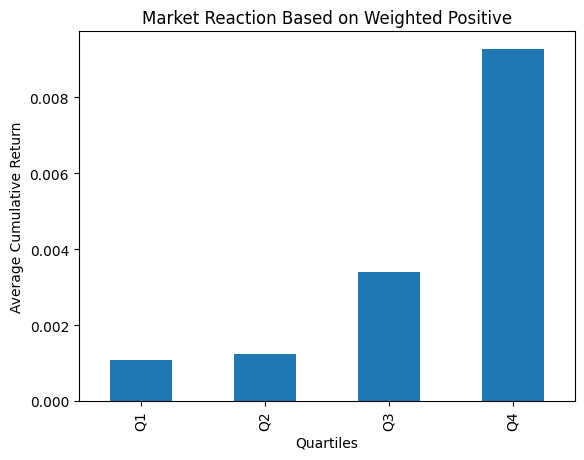

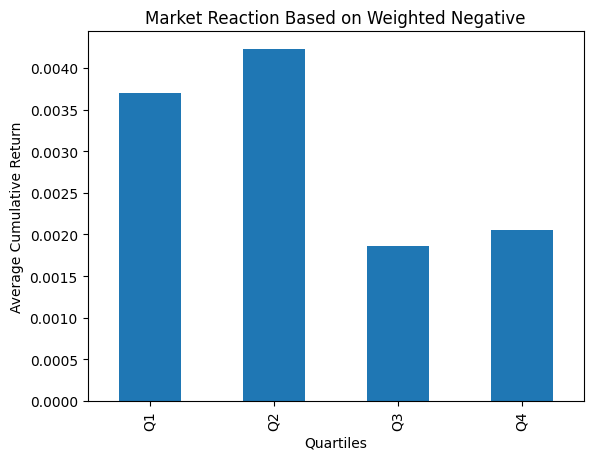

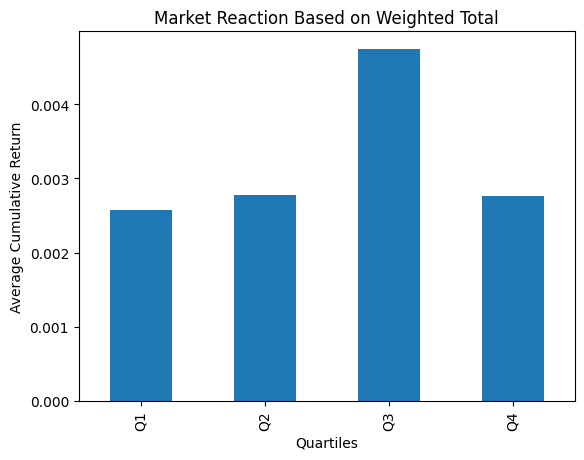

Data successfully saved to Processed_Cumulative_Returns_Analyst.csv


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load your data files
data = pd.read_csv('weighted_output_def_ulti_analyst_def_and_def_final.csv')
ranges = pd.read_csv("quartile_ranges_output_weighted_def_and_def_final.csv")
returns_data = pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/General/dailyReturnsCurated.csv')

# Check if the 'Date' column is in Excel serial format and convert if necessary
if pd.api.types.is_numeric_dtype(data['Date']):
    print("Converting Excel serial dates to datetime...")
    data['Date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(data['Date'], unit='D')
else:
    print("Converting 'Date' column to datetime format...")
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%b-%d', errors='coerce')

# Drop rows with invalid dates
if data['Date'].isnull().any():
    print("Warning: Invalid dates found in 'Date'. These rows will be dropped.")
    data = data.dropna(subset=['Date'])

# Ensure the 'date' column in returns data is in datetime format
returns_data['date'] = pd.to_datetime(returns_data['date'], format='%d/%m/%Y')

# Ensure 'RET' column in returns data is numeric
returns_data['RET'] = pd.to_numeric(returns_data['RET'], errors='coerce')

# Handle missing or invalid RET values
if returns_data['RET'].isnull().any():
    print("Warning: Non-numeric or missing values found in 'RET'. These will be ignored.")
    returns_data = returns_data.dropna(subset=['RET'])

# Function to calculate cumulative returns
def calculate_cumulative_returns_vectorized(ticker, start_date, end_date, returns_data):
    filtered_data = returns_data[
        (returns_data['TICKER'] == ticker) &
        (returns_data['date'] >= start_date) &
        (returns_data['date'] <= end_date)
    ]
    if not filtered_data.empty:
        return (filtered_data['RET'] + 1).prod() - 1
    return None

# Add progress bar to cumulative return calculation
cumulative_returns = []
for _, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing cumulative returns"):
    ticker = row['TICKER']
    start_date = row['Date']
    end_date = start_date + timedelta(days=3)  # Adjust for 3 days
    cumulative_returns.append(calculate_cumulative_returns_vectorized(ticker, start_date, end_date, returns_data))

data['Cumulative_Return'] = cumulative_returns

# Assign quartiles based on ranges
def assign_quartile(value, quartile_ranges, column):
    if value < quartile_ranges.loc['Q1_min', column]:
        return 'Q1'
    elif value < quartile_ranges.loc['Q2_min', column]:
        return 'Q2'
    elif value < quartile_ranges.loc['Q3_min', column]:
        return 'Q3'
    else:
        return 'Q4'

# Set the correct index for ranges
ranges.set_index(ranges.columns[0], inplace=True)

# Assign quartiles for Weighted_Positive, Weighted_Negative, and Weighted_Total
data['Positive_Quartile'] = data['Weighted_Positive'].apply(
    lambda x: assign_quartile(x, ranges, 'Weighted_Positive')
)
data['Negative_Quartile'] = data['Weighted_Negative'].apply(
    lambda x: assign_quartile(x, ranges, 'Weighted_Negative')
)
data['Total_Quartile'] = data['Weighted_Total'].apply(
    lambda x: assign_quartile(x, ranges, 'Weighted_Total')
)

# Plot the results
def plot_quartiles(data, column, title):
    quartile_means = data.groupby(f'{column}_Quartile')['Cumulative_Return'].mean()
    quartile_means.plot(kind='bar')
    plt.title(f'Market Reaction Based on {title}')
    plt.xlabel('Quartiles')
    plt.ylabel('Average Cumulative Return')
    plt.show()

plot_quartiles(data, 'Positive', 'Weighted Positive')
plot_quartiles(data, 'Negative', 'Weighted Negative')
plot_quartiles(data, 'Total', 'Weighted Total')

# Save the final data to a CSV file
output_path = "Processed_Cumulative_Returns_Analyst.csv"  # Adjust the path as needed
data.to_csv(output_path, index=False)
print(f"Data successfully saved to {output_path}")


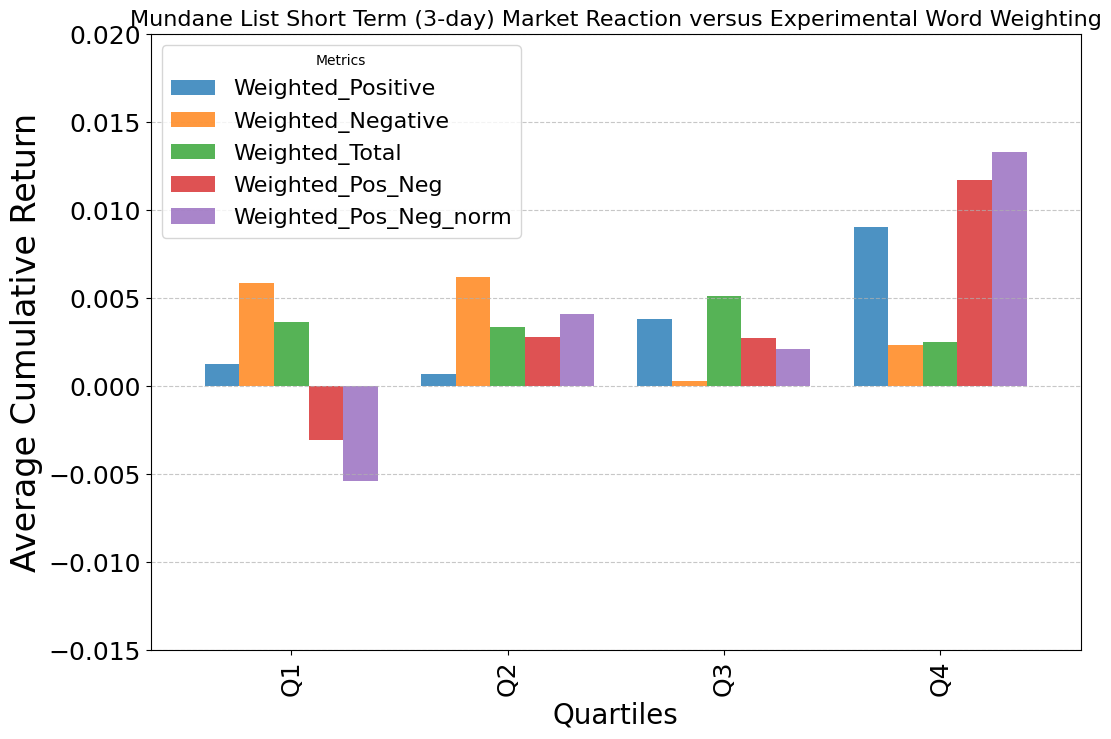

Modulus of Q1 - Q4 differences for each metric:
Weighted_Positive: 0.007747259501392647
Weighted_Negative: 0.0035488044771804575
Weighted_Total: 0.0011665971490984446
Weighted_Pos_Neg: 0.014732996102819591
Weighted_Pos_Neg_norm: 0.018697691687005524


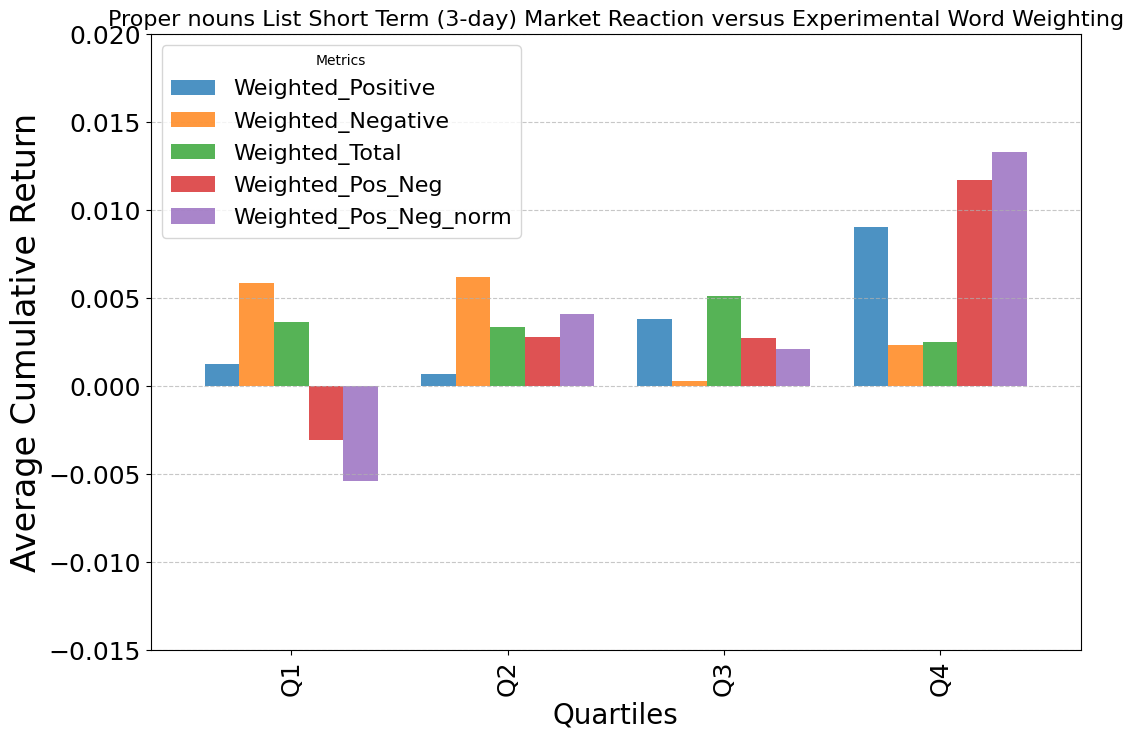

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
data_option_1 = pd.read_csv('/Users/jjdlg/Desktop/Robust for publication/Publication 2_3 - vecorised/Combined names factors/Final/Analyst/Analyst_finito/Processed_Cumulative_Returns_Analyst.csv')
data_option_2 = pd.read_csv('Processed_Cumulative_Returns_Analyst.csv')

# Strip column names to avoid issues with trailing spaces
data_option_1.columns = data_option_1.columns.str.strip()
data_option_2.columns = data_option_2.columns.str.strip()

# Function to assign quartiles based on item count
def assign_quartile_by_count(data, column):
    # Sort data by the column
    sorted_data = data.sort_values(by=column).reset_index(drop=True)

    # Split data into quartiles
    quartile_indices = {
        'Q1': sorted_data.iloc[: len(sorted_data) // 4].index,
        'Q2': sorted_data.iloc[len(sorted_data) // 4 : len(sorted_data) // 2].index,
        'Q3': sorted_data.iloc[len(sorted_data) // 2 : 3 * len(sorted_data) // 4].index,
        'Q4': sorted_data.iloc[3 * len(sorted_data) // 4 :].index,
    }

    # Assign quartiles to the data
    for quartile, indices in quartile_indices.items():
        sorted_data.loc[indices, f'{column}_Quartile'] = quartile

    # Drop rows without quartile assignments
    sorted_data = sorted_data.dropna(subset=[f'{column}_Quartile'])

    return sorted_data

# Columns to process
columns_option_1 = ['Weighted_Positive', 'Weighted_Negative', 'Weighted_Total']
columns_option_2 = ['Weighted_Pos_Neg', 'Weighted_Pos_Neg_norm']

# Remove rows with zero values
data_option_1 = data_option_1[(data_option_1[columns_option_1] != 0).all(axis=1)].reset_index(drop=True)
data_option_2 = data_option_2[(data_option_2[columns_option_2] != 0).all(axis=1)].reset_index(drop=True)

# Assign quartiles
for col in columns_option_1:
    data_option_1 = assign_quartile_by_count(data_option_1, col)

for col in columns_option_2:
    data_option_2 = assign_quartile_by_count(data_option_2, col)

# Invert quartiles for Option 2
quartile_mapping = {'Q1': 'Q1', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4'}
for col in columns_option_2:
    data_option_2[f'{col}_Quartile_Inverted'] = data_option_2[f'{col}_Quartile'].map(quartile_mapping)

# Drop rows with missing inverted quartile assignments
data_option_2 = data_option_2.dropna(subset=[f'{col}_Quartile_Inverted' for col in columns_option_2])

# Combined Plot
def plot_combined_options(data1, cols1, data2, cols2, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    quartile_means = {}

    # Process Option 1 data
    for col in cols1:
        quartile_stats = data1.groupby(f'{col}_Quartile')['Cumulative_Return'].mean()
        quartile_means[col] = quartile_stats

    # Process Option 2 inverted quartiles
    for col in cols2:
        quartile_stats_inverted = data2.groupby(f'{col}_Quartile_Inverted')['Cumulative_Return'].mean()
        quartile_means[col] = quartile_stats_inverted

    # Create DataFrame for combined data
    combined_quartiles = pd.DataFrame(quartile_means)


    # Plot
    combined_quartiles.plot(kind='bar', ax=ax, alpha=0.8, width=0.8)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Quartiles', fontsize=20)
    ax.set_ylabel('Average Cumulative Return', fontsize=24)
    ax.tick_params(axis='both', labelsize=18)
    ax.legend(title='Metrics', title_fontsize=10, fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(-0.015, 0.02)

    return combined_quartiles

    
# Plot the combined results
plot_combined_options(
    data_option_1, 
    columns_option_1, 
    data_option_2, 
    columns_option_2, 
    "Mundane List Short Term (3-day) Market Reaction versus Experimental Word Weighting"
)

# Show the plot
plt.show()

# Plot combined results and get combined_quartiles DataFrame
combined_quartiles = plot_combined_options(
    data_option_1, 
    columns_option_1, 
    data_option_2, 
    columns_option_2, 
    "Proper nouns List Short Term (3-day) Market Reaction versus Experimental Word Weighting"
)
# Calculate modulus of Q1 - Q4 for each metric
def calculate_modulus_diff_simple(combined_quartiles):
    modulus_differences = {}
    for col in combined_quartiles.columns:
        try:
            q1 = combined_quartiles.loc['Q1', col]
            q4 = combined_quartiles.loc['Q4', col]
            modulus_differences[col] = abs(q1 - q4)
        except KeyError:
            print(f"Error: Missing Q1 or Q4 data for column {col}.")
    return modulus_differences

# Example usage after `combined_quartiles` is created
modulus_differences = calculate_modulus_diff_simple(combined_quartiles)

# Print the results
print("Modulus of Q1 - Q4 differences for each metric:")
for metric, value in modulus_differences.items():
    print(f"{metric}: {value}")
